# Capstone Project - The Battle of the Neighborhoods (Week 2)
### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)



## Introduction: Business Problem <a name="introduction"></a>

- Background
	New York City is composed of five boroughs, Manhattan, Brooklyn, the Bronx, Queens, and Staten Island, each composed of several neighborhoods with diverse cultures and lifestyles. Of the five boroughs, Manhattan is arguably the most recognizable and alluring location for those aspiring to find their career in the “administrative, business, and financial center” of New York and, possibly, the United States1. According to Neighborhood Scout, Manhattan sees approximately 35,200 violent and property crimes annually and has a Crime Index of 30, meaning it is safer than 30% of U.S. cities2. As with any major decision involving the establishment of residence, personal and property safety is an important factor to consider when choosing a neighborhood for oneself or one’s family. Therefore, the ability to decide a neighborhood based on available crime data and proximity to safe spots would be beneficial for a prospective resident of Manhattan.


- Problem
	A new President of Finance has been hired by an investment bank in Manhattan and must decide which neighborhood he should relocate his family to from his current home in San Francisco. Given his hefty corporate salary and attractive bonus structure, he is less worried about cost and more worried about safety for his family. Being an avid martial arts practitioner, he also wants to make sure that his new home is in close proximity to a dojo where he can continue to polish his karate skills. As part of his contract, the investment bank has hired this Data Scientist to analyze potential neighborhoods that would fulfill their new President of Finance’s criteria.


- Interest
	In addition to the investment banker being interested in his new potential living situation, any resident or potential resident of Manhattan may be interested in having an informed view of neighborhood safety within the borough.

## Data <a name="data"></a>

Based on definition of the problem, factors that will influence a decision are:

- Number and type of crimes in Manhattan
- Distance of crimes to each major neighborhood in Manhattan
- Proximity to martial arts dojos

Following data sources will be need to obtain the required information:
- Latitude and longitude of neighborhoods within the borough of Manhattan (downloaded from https://geo.nyu.edu/catalog/nyu_2451_34572)
- Number of martial arts dojos and locations in every neighborhood will be obtained using **Foursquare API**
- New York City crime data will be downloaded from **Kaggle** at https://www.kaggle.com/adamschroeder/crimes-new-york-city.

### Import Libraries

In [1]:
import numpy as np

import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json

from geopy.geocoders import Nominatim

import requests
from pandas.io.json import json_normalize

import matplotlib.cm as cm
import matplotlib.colors as colors

from sklearn.cluster import KMeans

import folium

### Load Data and Instantiate Neighborhoods DataFrame

In [2]:
with open('nyu-2451-34572-geojson.json') as json_data:
    newyork_data = json.load(json_data)

Create neighborhoods DataFrame with pandas

In [3]:
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

neighborhoods = pd.DataFrame(columns=column_names)

neighborhoods_data = newyork_data['features']

Fill the neighborhoods DataFrame with data from newyork_data

In [4]:
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

Check neighborhoods DataFrame

In [5]:
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


### Create Manhattan neighborhoods DataFrame

Segment and cluster only the Manhattan neighborhoods within the DataFrame

In [6]:
manhattan_data = neighborhoods[neighborhoods['Borough'] == 'Manhattan'].reset_index(drop=True)
manhattan_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Manhattan,Marble Hill,40.876551,-73.910660
1,Manhattan,Chinatown,40.715618,-73.994279
2,Manhattan,Washington Heights,40.851903,-73.936900
3,Manhattan,Inwood,40.867684,-73.921210
4,Manhattan,Hamilton Heights,40.823604,-73.949688


In [7]:
manhattan_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 4 columns):
Borough         40 non-null object
Neighborhood    40 non-null object
Latitude        40 non-null float64
Longitude       40 non-null float64
dtypes: float64(2), object(2)
memory usage: 1.3+ KB


### Draw Manhattan Neighborhoods Map

Get geographical coordinates of Manhattan

In [8]:
address = 'Manhattan, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Manhattan are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Manhattan are 40.7896239, -73.9598939.


Visualize Manhattan and its neighborhoods

In [9]:
map_manhattan = folium.Map(location=[latitude, longitude], zoom_start=11)

for lat, lng, label in zip(manhattan_data['Latitude'], manhattan_data['Longitude'], manhattan_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_manhattan)  
    
map_manhattan

### Load Data and Instantiate Manhattan Crime DataFrame

In [10]:
ny_crimes = pd.read_csv('NYPD_Complaint_Data_Historic.csv')

C:\Users\sbrown8\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [11]:
manhattan_crimes = ny_crimes[ny_crimes['BORO_NM'] == 'MANHATTAN']

### Create a new dataframe with only the needed columns

In [12]:
manhattan_crimes.head()

,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,RPT_DT,KY_CD,OFNS_DESC,PD_CD,PD_DESC,CRM_ATPT_CPTD_CD,LAW_CAT_CD,JURIS_DESC,BORO_NM,ADDR_PCT_CD,LOC_OF_OCCUR_DESC,PREM_TYP_DESC,PARKS_NM,HADEVELOPT,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Lat_Lon
2,569369778,12/31/2015,23:30:00,NaN,NaN,12/31/2015,117,DANGEROUS DRUGS,503.0,"CONTROLLED SUBSTANCE,INTENT TO",COMPLETED,FELONY,N.Y. POLICE DEPT,MANHATTAN,28.0,NaN,OTHER,NaN,NaN,999463.0,231690.0,40.802607,-73.945052,"(40.802606608, -73.945051911)"
4,641637920,12/31/2015,23:25:00,12/31/2015,23:30:00,12/31/2015,344,ASSAULT 3 & RELATED OFFENSES,101.0,ASSAULT 3,COMPLETED,MISDEMEANOR,N.Y. POLICE DEPT,MANHATTAN,13.0,FRONT OF,OTHER,NaN,NaN,987606.0,208148.0,40.738002,-73.987891,"(40.7380024, -73.98789129)"
6,608231454,12/31/2015,23:15:00,NaN,NaN,12/31/2015,235,DANGEROUS DRUGS,511.0,"CONTROLLED SUBSTANCE, POSSESSI",COMPLETED,MISDEMEANOR,N.Y. POLICE DEPT,MANHATTAN,7.0,OPPOSITE OF,STREET,NaN,NaN,987373.0,201662.0,40.720200,-73.988735,"(40.720199996, -73.988735082)"
9,415095955,12/31/2015,23:10:00,12/31/2015,23:10:00,12/31/2015,341,PETIT LARCENY,338.0,"LARCENY,PETIT FROM BUILDING,UN",COMPLETED,MISDEMEANOR,N.Y. POLICE DEPT,MANHATTAN,19.0,INSIDE,DRUG STORE,NaN,NaN,994327.0,218211.0,40.765618,-73.963623,"(40.765617688, -73.96362342)"
11,178090167,12/31/2015,23:00:00,12/31/2015,23:05:00,12/31/2015,341,PETIT LARCENY,338.0,"LARCENY,PETIT FROM BUILDING,UN",COMPLETED,MISDEMEANOR,N.Y. POLICE DEPT,MANHATTAN,13.0,INSIDE,RESTAURANT/DINER,NaN,NaN,988113.0,206263.0,40.732828,-73.986063,"(40.732828332, -73.986062857)"


In [13]:
manhattan_crimes = manhattan_crimes[['RPT_DT','LAW_CAT_CD','Latitude','Longitude']].copy()

In [14]:
manhattan_crimes.head()

,RPT_DT,LAW_CAT_CD,Latitude,Longitude
2,12/31/2015,FELONY,40.802607,-73.945052
4,12/31/2015,MISDEMEANOR,40.738002,-73.987891
6,12/31/2015,MISDEMEANOR,40.720200,-73.988735
9,12/31/2015,MISDEMEANOR,40.765618,-73.963623
11,12/31/2015,MISDEMEANOR,40.732828,-73.986063


### Only include most recent crime reports in analysis

In [15]:
manhattan_2015_crimes = manhattan_crimes[manhattan_crimes['RPT_DT']=='12/31/2015'].dropna()

In [33]:
manhattan_2015_crimes.head()

,RPT_DT,LAW_CAT_CD,Latitude,Longitude
2,12/31/2015,FELONY,40.802607,-73.945052
4,12/31/2015,MISDEMEANOR,40.738002,-73.987891
6,12/31/2015,MISDEMEANOR,40.720200,-73.988735
9,12/31/2015,MISDEMEANOR,40.765618,-73.963623
11,12/31/2015,MISDEMEANOR,40.732828,-73.986063


## Split DataFrame into Felony and Misdemeanor Crimes

In [17]:
felony_crimes = manhattan_2015_crimes[manhattan_2015_crimes['LAW_CAT_CD']=='FELONY'].dropna()
misdemeanor_crimes = manhattan_2015_crimes[manhattan_2015_crimes['LAW_CAT_CD']=='MISDEMEANOR'].dropna()

In [40]:
felony_crimes.head()

,RPT_DT,LAW_CAT_CD,Latitude,Longitude
2,12/31/2015,FELONY,40.802607,-73.945052
12,12/31/2015,FELONY,40.757916,-73.989299
13,12/31/2015,FELONY,40.757916,-73.989299
16,12/31/2015,FELONY,40.755197,-73.968296
34,12/31/2015,FELONY,40.742781,-73.986598


In [32]:
misdemeanor_crimes.head()

,RPT_DT,LAW_CAT_CD,Latitude,Longitude
4,12/31/2015,MISDEMEANOR,40.738002,-73.987891
6,12/31/2015,MISDEMEANOR,40.720200,-73.988735
9,12/31/2015,MISDEMEANOR,40.765618,-73.963623
11,12/31/2015,MISDEMEANOR,40.732828,-73.986063
31,12/31/2015,MISDEMEANOR,40.720664,-73.988064


## Add Crime Reports to Manhattan Map

In [20]:
for lat, lng, label in zip(felony_crimes['Latitude'], felony_crimes['Longitude'], felony_crimes['LAW_CAT_CD']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=2,
        popup=label,
        color='red',
        fill=True,
        fill_color='#eb3434',
        fill_opacity=1,
        parse_html=False).add_to(map_manhattan)  
    
for lat, lng, label in zip(misdemeanor_crimes['Latitude'], misdemeanor_crimes['Longitude'], misdemeanor_crimes['LAW_CAT_CD']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=2,
        popup=label,
        color='yellow',
        fill=True,
        fill_color='#ebe834',
        fill_opacity=1,
        parse_html=False).add_to(map_manhattan)  
    
map_manhattan

### Foursquare
#### Use Foursquare API to find martial arts dojos located in Manhattan

Foursquare credentials are defined in hidden cell bellow.

In [21]:
CLIENT_ID = 'H55MWH3AM0FIOPRZUR5HGTSKEPLZI2QDKVURCDVAXDSECU0G'
CLIENT_SECRET = 'Z3RMOYMHAN1YCOOKCVTOEK4LN5VCCTUYBZDDDNOWIMNIKS3Y'
VERSION = '20191112'

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: H55MWH3AM0FIOPRZUR5HGTSKEPLZI2QDKVURCDVAXDSECU0G
CLIENT_SECRET:Z3RMOYMHAN1YCOOKCVTOEK4LN5VCCTUYBZDDDNOWIMNIKS3Y


Drop NaNs from Manhattan dataset and define a function that will pull data from Foursquare via the API

In [22]:
manhattan_data.dropna(inplace=True)

In [23]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Run function and gather all venues in Manhattan

In [24]:
LIMIT = 100

radius = 10000

manhattan_venues = getNearbyVenues(names=manhattan_data['Neighborhood'],
                                   latitudes=manhattan_data['Latitude'],
                                   longitudes=manhattan_data['Longitude']
                                  )

Marble Hill
Chinatown
Washington Heights
Inwood
Hamilton Heights
Manhattanville
Central Harlem
East Harlem
Upper East Side
Yorkville
Lenox Hill
Roosevelt Island
Upper West Side
Lincoln Square
Clinton
Midtown
Murray Hill
Chelsea
Greenwich Village
East Village
Lower East Side
Tribeca
Little Italy
Soho
West Village
Manhattan Valley
Morningside Heights
Gramercy
Battery Park City
Financial District
Carnegie Hill
Noho
Civic Center
Midtown South
Sutton Place
Turtle Bay
Tudor City
Stuyvesant Town
Flatiron
Hudson Yards


In [25]:
print(manhattan_venues.shape)
manhattan_venues.head()

(3305, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Marble Hill,40.876551,-73.91066,Arturo's,40.874412,-73.910271,Pizza Place
1,Marble Hill,40.876551,-73.91066,Bikram Yoga,40.876844,-73.906204,Yoga Studio
2,Marble Hill,40.876551,-73.91066,Tibbett Diner,40.880404,-73.908937,Diner
3,Marble Hill,40.876551,-73.91066,Starbucks,40.877531,-73.905582,Coffee Shop
4,Marble Hill,40.876551,-73.91066,Blink Fitness Riverdale,40.877147,-73.905837,Gym


Filter the manhattan_venues DataFrame to leave only the Martial Arts Dojos

In [26]:
dojos = manhattan_venues[manhattan_venues['Venue Category']=='Martial Arts Dojo']

Rename Longitude and Latitude columns for consistency

In [36]:
dojos.rename(columns={'Venue Latitude':'Latitude','Venue Longitude':'Longitude'})

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Latitude,Longitude,Venue Category
1228,Murray Hill,40.748303,-73.978332,Coban's Muay Thai Camp,40.750355,-73.981554,Martial Arts Dojo
1763,Little Italy,40.719324,-73.997305,Five Points Academy,40.719566,-73.999819,Martial Arts Dojo
1921,Soho,40.722184,-74.000657,Five Points Academy,40.719566,-73.999819,Martial Arts Dojo
2501,Carnegie Hill,40.782683,-73.953256,Modern Martial Arts NYC Eastside,40.778487,-73.953136,Martial Arts Dojo
2635,Civic Center,40.715229,-74.005415,Modern Martial Arts NYC Tribeca,40.715431,-74.007362,Martial Arts Dojo
2715,Civic Center,40.715229,-74.005415,The Wat Gym,40.714830,-74.006036,Martial Arts Dojo
2935,Turtle Bay,40.752042,-73.967708,I Love Kickboxing - 43rd Street,40.750580,-73.971540,Martial Arts Dojo
3030,Tudor City,40.746917,-73.971219,I Love Kickboxing - 43rd Street,40.750580,-73.971540,Martial Arts Dojo
3220,Flatiron,40.739673,-73.990947,World Seido Karate Honbu,40.742576,-73.992042,Martial Arts Dojo


In [37]:
dojos.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Latitude,Longitude,Venue Category
1228,Murray Hill,40.748303,-73.978332,Coban's Muay Thai Camp,40.750355,-73.981554,Martial Arts Dojo
1763,Little Italy,40.719324,-73.997305,Five Points Academy,40.719566,-73.999819,Martial Arts Dojo
1921,Soho,40.722184,-74.000657,Five Points Academy,40.719566,-73.999819,Martial Arts Dojo
2501,Carnegie Hill,40.782683,-73.953256,Modern Martial Arts NYC Eastside,40.778487,-73.953136,Martial Arts Dojo
2635,Civic Center,40.715229,-74.005415,Modern Martial Arts NYC Tribeca,40.715431,-74.007362,Martial Arts Dojo


## Add Dojos to Map

In [28]:
for lat, lng, label in zip(dojos['Venue Latitude'], dojos['Venue Longitude'], dojos['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=8,
        popup=label,
        color='green',
        fill=True,
        fill_color='#168011',
        fill_opacity=1,
        parse_html=False).add_to(map_manhattan)  
    
map_manhattan

The data gathering phase is complete. Now the data can be used to determine the optimal neighborhoods for a new resident of New York City!

## Methodology <a name="methodology"></a>

In this project we will determine which neighborhood maximizes a location score calculated using the following equation:

Score = ((0.8×C_F+0.2×C_M ))/C_D, where CF is the distance to the centroid of Felony Crimes, CM is the distance to the centroid of Misdemeanor crimes, and CD is the distance to the centroid of dojos

In first step the required was collected: **location of all Manhattan neighborhoods, felony and misdemeanor crimes, and martial arts dojos

Second step in the analysis will be calculation and exploration of '**cluster centroids**' for the crime and martial arts dojo datasets.

In third and final step, the score equation will be used to determine which neighborhood is optimally located to **maximize the location score**. This neighborhood would be the highest priority location for the President of Finance and his family.

## Analysis <a name="analysis"></a>

First, calculate centroids for each dataset using the centroid formula and visualize them on the Manhattan map. Start by defining a function for calculating a centroid.

In [48]:
def centroid(df):
    x_values = []
    y_values = []
    for i in range(len(df.index)):
        x_values.append(df.iloc[i]['Latitude'])
        y_values.append(df.iloc[i]['Longitude'])
    
    x = sum(x_values)
    y = sum(y_values)
    
    return ((x/len(x_values)),(y/len(y_values)))

#### Felony Crimes Centroid

In [49]:
felony_centroid = centroid(felony_crimes)
felony_centroid

(40.77285259705882, -73.97293642617643)

In [50]:
misdemeanor_centroid = centroid(misdemeanor_crimes)
misdemeanor_centroid

(40.773041652385324, -73.97014819018351)

In [51]:
dojo_centroid = centroid(dojos)
dojo_centroid

(40.73799680963727, -73.98698294953242)

### Add Centroid markers to Map

In [52]:
folium.Marker(list(felony_centroid), popup='<i>Felony Centroid</i>', tooltip='Felony Centroid').add_to(map_manhattan)

folium.Marker(list(misdemeanor_centroid), popup='<i>Misdemeanor Centroid</i>', tooltip='Misdemeanor Centroid').add_to(map_manhattan)

folium.Marker(list(dojo_centroid), popup='<i>Dojo Centroid</i>', tooltip='Dojo Centroid').add_to(map_manhattan)

map_manhattan

### Location Score Calculation for Each Neighborhood

In [54]:
def distance_score(n_loc,fel_c,mis_c,dojo_c):
    n_x = n_loc[0]
    n_y = n_loc[1]
    
    fel_dist = ((fel_c[0]-n_x)**2+(fel_c[1]-n_y)**2)**0.5
    
    mis_dist = ((mis_c[0]-n_x)**2+(mis_c[1]-n_y)**2)**0.5
    
    dojo_dist = ((dojo_c[0]-n_x)**2+(dojo_c[1]-n_y)**2)**0.5
    
    return (((0.8*fel_dist)+(0.2*mis_dist))/dojo_dist)
    

Instantiate DataFrame for Location Scores

In [66]:
score_df = manhattan_data.drop(['Borough','Latitude','Longitude'],axis=1)

In [69]:
score_df['Score']=0

In [70]:
score_df.head()

,Neighborhood,Score
0,Marble Hill,0
1,Chinatown,0
2,Washington Heights,0
3,Inwood,0
4,Hamilton Heights,0


Calculate Neighborhood scores and add to DataFrame

In [82]:
for i in range(len(score_df)):
    
    nloc_x = manhattan_data.iloc[i]['Latitude']
    nloc_y = manhattan_data.iloc[i]['Longitude']
    
    n_centroid = (nloc_x,nloc_y)
    
    score_df['Score'][i] = float(distance_score(n_centroid,felony_centroid,misdemeanor_centroid,dojo_centroid))
    
score_df.info()

C:\Users\sbrown8\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


<class 'pandas.core.frame.DataFrame'>
Int64Index: 40 entries, 0 to 39
Data columns (total 2 columns):
Neighborhood    40 non-null object
Score           40 non-null int64
dtypes: int64(1), object(1)
memory usage: 2.2+ KB


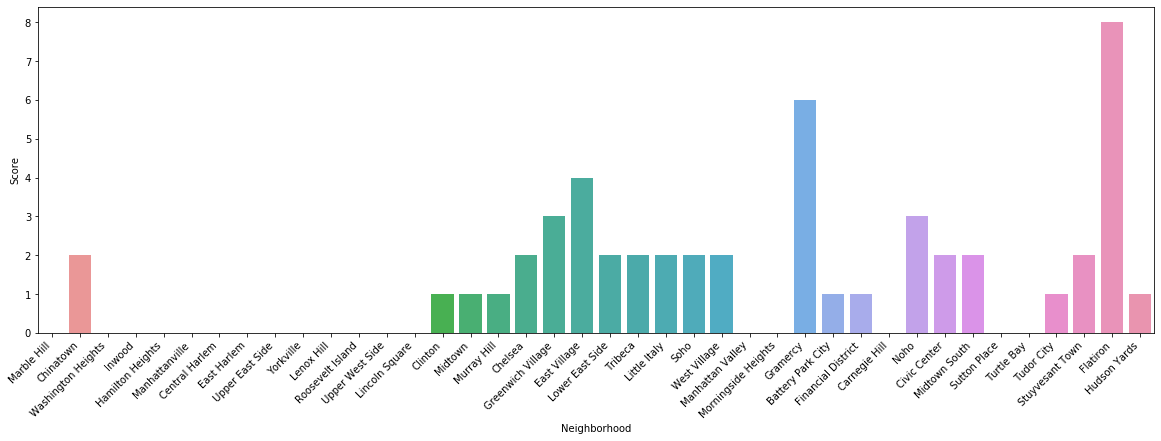

In [137]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(20,6))

chart = sns.barplot(x='Neighborhood',y='Score',data=score_df)

score_chart = chart.set_xticklabels(chart.get_xticklabels(),rotation=45,horizontalalignment='right')

Find Best Location (Max Score) from Score DataFrame

In [89]:
score_df['Neighborhood'][score_df['Score'].idxmax()]

'Flatiron'

## Results and Discussion <a name="results"></a>

Our analysis shows that the Flatiron neighborhood in Manhattan is the best location for the President of Finance and his family. The Neighborhood is farthest from the epicenter of city crime and closest to the martial arts dojos that the PoF enjoys in his spare time. The neighborhood location and final results map are shown below:

In [109]:
flatiron = manhattan_data[manhattan_data['Neighborhood']=='Flatiron']

flatiron

,Borough,Neighborhood,Latitude,Longitude
38,Manhattan,Flatiron,40.739673,-73.990947


In [114]:
flatiron_x = flatiron.iloc[0]['Latitude']
flatiron_y = flatiron.iloc[0]['Longitude']

In [117]:
map_manhattan_final = folium.Map(location=[latitude, longitude], zoom_start=11)

for lat, lng, label in zip(felony_crimes['Latitude'], felony_crimes['Longitude'], felony_crimes['LAW_CAT_CD']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=2,
        popup=label,
        color='red',
        fill=True,
        fill_color='#eb3434',
        fill_opacity=1,
        parse_html=False).add_to(map_manhattan_final)  
    
for lat, lng, label in zip(misdemeanor_crimes['Latitude'], misdemeanor_crimes['Longitude'], misdemeanor_crimes['LAW_CAT_CD']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=2,
        popup=label,
        color='yellow',
        fill=True,
        fill_color='#ebe834',
        fill_opacity=1,
        parse_html=False).add_to(map_manhattan_final)
    
for lat, lng, label in zip(dojos['Latitude'], dojos['Longitude'], dojos['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=8,
        popup=label,
        color='green',
        fill=True,
        fill_color='#168011',
        fill_opacity=1,
        parse_html=False).add_to(map_manhattan_final)  
    
folium.Marker([flatiron_x,flatiron_y], popup='<i>Flatiron Neighborhood</i>', tooltip='Flatiron Neighborhood').add_to(map_manhattan_final)

map_manhattan_final

## Conclusion <a name="conclusion"></a>

The purpose of this project was to identify a Manhattan neighborhood for an investment bank's new President of Finance that would be optimally located based on available crime data and proximity to martial arts dojos, the President's favorite pastime. 

Using data analytics and available Python libraries, it was determined that the best neighborhood for the President and his family would be **Flatiron**.